<a href="https://colab.research.google.com/github/ngupta23/fastai_notebooks/blob/master/lesson1_pets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 1 - What's your pet

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [38]:
# Checking version
import fastai
fastai.__version__

'1.0.58'

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [3]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [43]:
help(untar_data)

## SHOWS:
#  Where it came from
#  What does it do
#  arguments and types (UNION means either of the following)
#  default values

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [63]:
doc(untar_data)
help(untar_data) # less pretty formating but inline in notebook

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [5]:
URLs.PETS

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet'

In [10]:
# path = untar_data(url = URLs.PETS)  # For Colab
path = untar_data(url = URLs.PETS, dest = "data")  # For local computer (might work on colab but not tested)
path  # This is a path object

WindowsPath('data/oxford-iiit-pet')

In [11]:
path.ls()

[WindowsPath('data/oxford-iiit-pet/annotations'),
 WindowsPath('data/oxford-iiit-pet/images')]

In [12]:
path_anno = path/'annotations'
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [13]:
fnames = get_image_files(path_img)
fnames[:5]

[WindowsPath('data/oxford-iiit-pet/images/Abyssinian_1.jpg'),
 WindowsPath('data/oxford-iiit-pet/images/Abyssinian_10.jpg'),
 WindowsPath('data/oxford-iiit-pet/images/Abyssinian_100.jpg'),
 WindowsPath('data/oxford-iiit-pet/images/Abyssinian_101.jpg'),
 WindowsPath('data/oxford-iiit-pet/images/Abyssinian_102.jpg')]

In [14]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [64]:
doc(get_transforms)
help(get_transforms)

Help on function get_transforms in module fastai.vision.transform:

get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10.0, max_zoom:float=1.1, max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75, p_lighting:float=0.75, xtra_tfms:Union[Collection[fastai.vision.image.Transform], NoneType]=None) -> Collection[fastai.vision.image.Transform]
    Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms.



In [22]:
imagenet_stats  # Mean and Standard Deviation used for imagenet

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [23]:
# Extracting labels using regular expressions
# NOTE: 
# (1) We need the 'path' as well as 'filenames' since the developed model will be saved in the path
# (2) Validation set defaults to 20%
data = ImageDataBunch.from_name_re(path=path_img,
                                   fnames=fnames,
                                   pat=pat,
                                   ds_tfms=get_transforms(),
                                   size=224,
                                   bs=bs
                                  ).normalize(imagenet_stats)

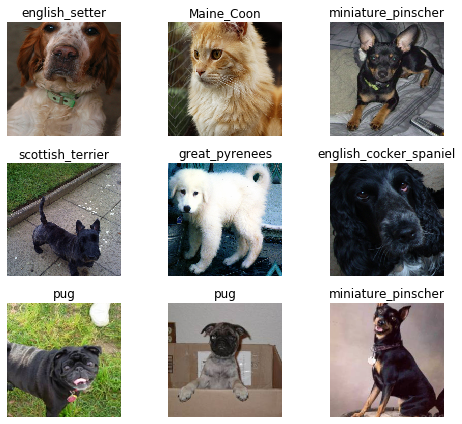

In [24]:
data.show_batch(rows=3, figsize=(7,6))

In [25]:
print(data.classes)
print(len(data.classes))
print(data.c)  # Analogous to number of classes for classification problems (not for regression problems)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']
37
37


## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [26]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\Nikhil/.torch\models\resnet34-333f7ec4.pth
100%|█████████████████████████████████████████████████████████████████| 87306240/87306240 [00:12<00:00, 6731876.88it/s]


In [27]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [28]:
# NOTE: 'fit_one_cycle' is preferred (faster and more accurate) over just 'fit'
learn.fit_one_cycle(4)

In [31]:
learn.save('stage-1')  # Saves it in the directory where the images exist (under a folder called 'models' in there)

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [39]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

In [67]:
doc(interp.plot_top_losses)
help(interp.plot_top_losses)

Help on method _cl_int_plot_top_losses in module fastai.vision.learner:

_cl_int_plot_top_losses(k, largest=True, figsize=(12, 12), heatmap:bool=False, heatmap_thresh:int=16, alpha:float=0.6, cmap:str='magma', show_text:bool=True, return_fig:bool=None) -> Union[matplotlib.figure.Figure, NoneType] method of fastai.train.ClassificationInterpretation instance
    Show images in `top_losses` along with their prediction, actual, loss, and probability of actual class.



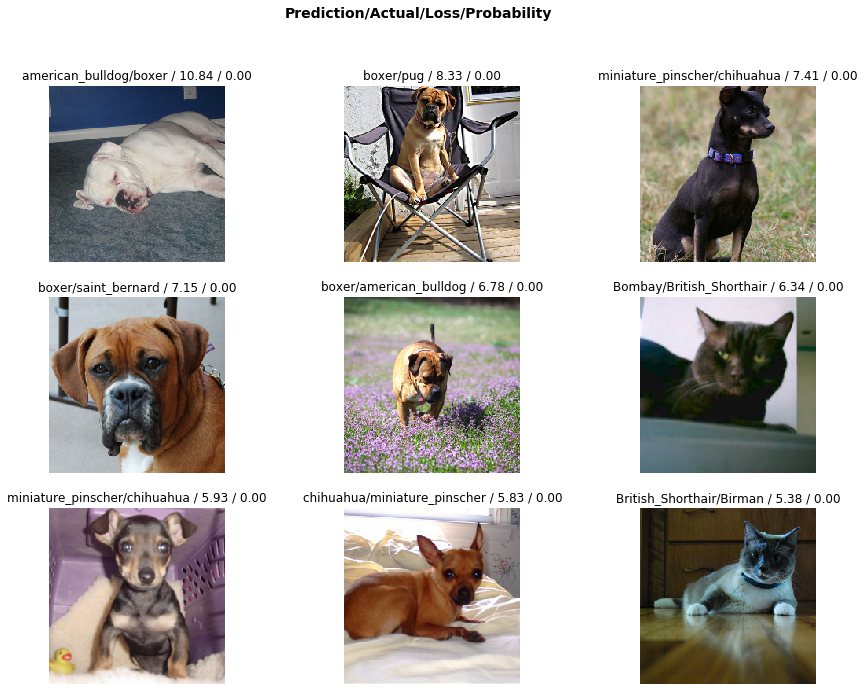

In [40]:
interp.plot_top_losses(9, figsize=(15,11))
# OUTPUT: prediction, actual, loss, and probability of actual class

In [66]:
doc(interp.plot_confusion_matrix)
help(interp.plot_confusion_matrix)

Help on method plot_confusion_matrix in module fastai.train:

plot_confusion_matrix(normalize:bool=False, title:str='Confusion matrix', cmap:Any='Blues', slice_size:int=1, norm_dec:int=2, plot_txt:bool=True, return_fig:bool=None, **kwargs) -> Union[matplotlib.figure.Figure, NoneType] method of fastai.train.ClassificationInterpretation instance
    Plot the confusion matrix, with `title` and using `cmap`.



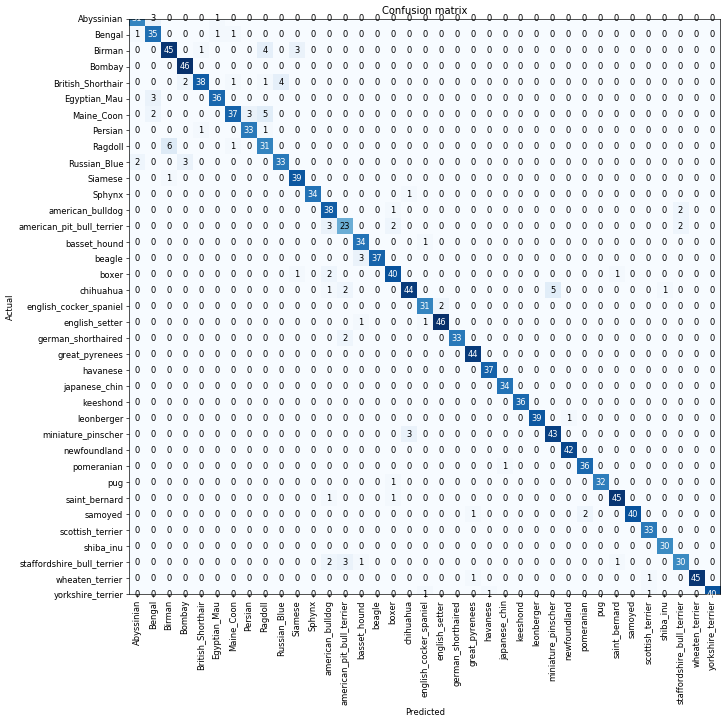

In [57]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [58]:
help(interp.most_confused)

Help on method most_confused in module fastai.train:

most_confused(min_val:int=1, slice_size:int=1) -> Collection[Tuple[str, str, int]] method of fastai.train.ClassificationInterpretation instance
    Sorted descending list of largest non-diagonal entries of confusion matrix, presented as actual, predicted, number of occurrences.



In [59]:
interp.most_confused(min_val=2)

[('Ragdoll', 'Birman', 6),
 ('Maine_Coon', 'Ragdoll', 5),
 ('chihuahua', 'miniature_pinscher', 5),
 ('Birman', 'Ragdoll', 4),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('Abyssinian', 'Bengal', 3),
 ('Birman', 'Siamese', 3),
 ('Egyptian_Mau', 'Bengal', 3),
 ('Maine_Coon', 'Persian', 3),
 ('Russian_Blue', 'Bombay', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3),
 ('beagle', 'basset_hound', 3),
 ('miniature_pinscher', 'chihuahua', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3),
 ('British_Shorthair', 'Bombay', 2),
 ('Maine_Coon', 'Bengal', 2),
 ('Russian_Blue', 'Abyssinian', 2),
 ('american_bulldog', 'staffordshire_bull_terrier', 2),
 ('american_pit_bull_terrier', 'boxer', 2),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 2),
 ('boxer', 'american_bulldog', 2),
 ('chihuahua', 'american_pit_bull_terrier', 2),
 ('english_cocker_spaniel', 'english_setter', 2),
 ('german_shorthaired', 'american_pit_bull_terrier', 2),
 ('samoyed', 'pomeranian', 2

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [68]:
# Without unfreezing, it was only training the head
# Unfreeze will train all layers 
learn.unfreeze() 

In [69]:
learn.fit_one_cycle(1)

Becomes worse because initial layers are learning small feastures. We are not likely to improve upon these with just 1 epoch. So lets reload the original one and **<font color = red>try to improve that with the learning rate finder.</font>**

In [70]:
learn.load('stage-1');

In [71]:
doc(lr_find)

In [73]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


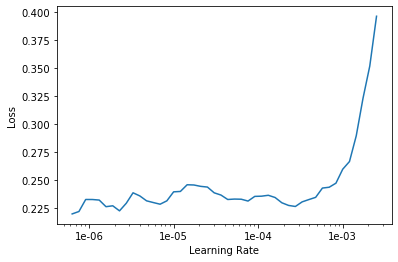

In [74]:
learn.recorder.plot()

`fit_one_cycle` has a default learing rate of 0.003 so we are in a regime where the loss is actually increasing.
We want to reduce that to say 1e-4 for the later layers (note that these later layers were running just fine earlier before unfreezing so we can use the larger learnign rate here). **But for the earlier layers, if we want to retrain them, we need to train them with a finer learning rate, so we start the first layer with say 1e-6 and then gradually increase that to 1e-4 as we get to the later layers (but no more since the loss will start to increase then)**

### <font color = red>RULE OF THUMB:</font>
* **End value is about 1 order of magnitude lower than the one in stage1 (which defaulted to 0.003 which is close to 1e-3, so we use ~ 1e-4)**
* **Start value should come form the learnig rate finder and should be well below the value at which the loss starts to become worse.**

In [75]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
data = ImageDataBunch.from_name_re(path_img,
                                   fnames,
                                   pat,
                                   ds_tfms=get_transforms(),
                                   size=299,
                                   bs=bs//2
                                  ).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


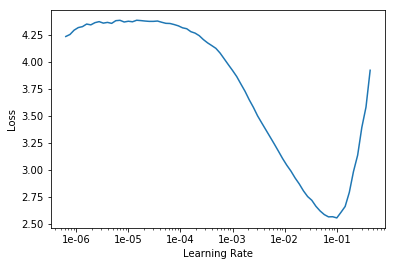

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8)

Total time: 06:59
epoch  train_loss  valid_loss  error_rate
1      0.548006    0.268912    0.076455    (00:57)
2      0.365533    0.193667    0.064953    (00:51)
3      0.336032    0.211020    0.073072    (00:51)
4      0.263173    0.212025    0.060893    (00:51)
5      0.217016    0.183195    0.063599    (00:51)
6      0.161002    0.167274    0.048038    (00:51)
7      0.086668    0.143490    0.044655    (00:51)
8      0.082288    0.154927    0.046008    (00:51)



In [0]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

Total time: 03:27
epoch  train_loss  valid_loss  error_rate
1      0.097319    0.155017    0.048038    (01:10)
2      0.074885    0.144853    0.044655    (01:08)
3      0.063509    0.144917    0.043978    (01:08)



If it doesn't, you can always go back to your previous model.

In [0]:
learn.load('stage-1-50');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Bengal', 'Abyssinian', 4),
 ('boxer', 'american_bulldog', 4),
 ('Ragdoll', 'Birman', 4),
 ('Egyptian_Mau', 'Bengal', 3)]

## Other data formats

In [76]:
path = untar_data(URLs.MNIST_SAMPLE); path

WindowsPath('C:/Users/Nikhil/.fastai/data/mnist_sample')

In [79]:
path.ls()

[WindowsPath('C:/Users/Nikhil/.fastai/data/mnist_sample/labels.csv'),
 WindowsPath('C:/Users/Nikhil/.fastai/data/mnist_sample/train'),
 WindowsPath('C:/Users/Nikhil/.fastai/data/mnist_sample/valid')]

### CASE 1: Classes are saved in individual folders

In [81]:
(path/'train').ls()

[WindowsPath('C:/Users/Nikhil/.fastai/data/mnist_sample/train/3'),
 WindowsPath('C:/Users/Nikhil/.fastai/data/mnist_sample/train/7')]

In [77]:
tfms = get_transforms(do_flip=False)  # We dont want to flip the images since numbers are not written flipped
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

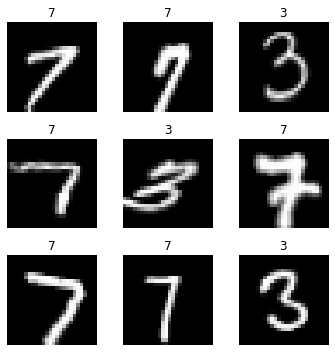

In [78]:
data.show_batch(rows=3, figsize=(5,5))

In [82]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\Nikhil/.torch\models\resnet18-5c106cde.pth
100%|█████████████████████████████████████████████████████████████████| 46827520/46827520 [00:07<00:00, 6542920.25it/s]


### CASE 2: Classes are saved in a csv file

In [83]:
path.ls()

[WindowsPath('C:/Users/Nikhil/.fastai/data/mnist_sample/labels.csv'),
 WindowsPath('C:/Users/Nikhil/.fastai/data/mnist_sample/train'),
 WindowsPath('C:/Users/Nikhil/.fastai/data/mnist_sample/valid')]

In [84]:
df = pd.read_csv(path/'labels.csv')
df.head()

name  label
0   train/3/7463.png      0
1  train/3/21102.png      0
2  train/3/31559.png      0
3  train/3/46882.png      0
4  train/3/26209.png      0

In [85]:
# Default file name to look for is 'labels.csv'. 
# If anything else, then the name needs to be passed into the method call
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

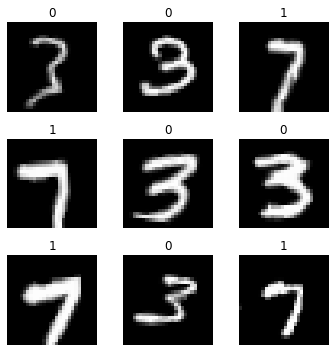

In [86]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

### CASE 3: Classes are saved in a pandas Dataframe

In [87]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

### CASE 4: Using regex (already seen above)

In [88]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[WindowsPath('C:/Users/Nikhil/.fastai/data/mnist_sample/train/3/7463.png'),
 WindowsPath('C:/Users/Nikhil/.fastai/data/mnist_sample/train/3/21102.png')]

In [89]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

### CASE 5: Using arbitrary function to extract class names

In [ ]:
linux = False

In [99]:
fn_paths[:2], fn_paths[-2:]

([WindowsPath('C:/Users/Nikhil/.fastai/data/mnist_sample/train/3/7463.png'),
  WindowsPath('C:/Users/Nikhil/.fastai/data/mnist_sample/train/3/21102.png')],
 [WindowsPath('C:/Users/Nikhil/.fastai/data/mnist_sample/valid/7/3166.png'),
  WindowsPath('C:/Users/Nikhil/.fastai/data/mnist_sample/valid/7/7149.png')])

In [106]:
data = ImageDataBunch.from_name_func(path,
                                     fn_paths,
                                     ds_tfms=tfms,
                                     size=24,
                                     #label_func = lambda x: '3' if '/3/' in str(x) else '7'  # Linux (Google Colab)
                                     label_func = lambda x: '3' if '\\3\\' in str(x) else '7'  # Windows
                                    )
data.classes

['3', '7']

### CASE 6: Using lists of labels ( not working )

In [108]:
#labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]  # Linux
labels = [('3' if '\\3\\' in str(x) else '7') for x in fn_paths]  # Windows
labels[:2], labels[-2:]

(['3', '3'], ['7', '7'])

In [109]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']